In [23]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from itertools import combinations

In [4]:
CAMERA_WALL_DISTANCE = 1 # m

data_dir = Path("data")

devices = {}

for device_dir in data_dir.iterdir():
	if not device_dir.is_dir():
		continue
	print(device_dir.name)

	images = {}
	for image_dir in device_dir.glob("*.png"):
		images[image_dir.stem] = cv2.imread(str(image_dir))

	devices[device_dir.name] = images



194430103120731300
1944301041C7751300
1944301041D0731300
1944301041D7761300
19443010D1C47E1300
19443010E1E6731300
19443010F1A9761300


In [5]:
aruco_dict = cv2.aruco.getPredefinedDictionary(cv2.aruco.DICT_6X6_250)

def get_corners(image):
	""" Get the corners of the noise pattern board """
	
	corners, ids, rejectedImgPoints = cv2.aruco.detectMarkers(image, aruco_dict)
	inds = np.argsort(ids.flatten())
	corners_sorted = np.array(corners)[inds]
	if len(corners_sorted) != 4:
		raise Exception("Noise pattern board not found")

	center = np.array([m.mean(axis=1).flatten() for m in corners_sorted]).mean(axis=0)

	points = []
	for m in corners_sorted:
		i = np.linalg.norm(m - center, axis=-1).argmin()
		points.append(m[:, i])

	points = np.array(points).reshape(-1, 2)

	return points

def get_center(points):
	center = points.mean(axis=0)
	return center[0], center[1]

def get_rotation(points):
	center_bottom = (points[0] + points[1]) / 2
	center_top = (points[2] + points[3]) / 2
	d = center_bottom - center_top
	angle = np.arctan2(*d)
	return angle

def get_board_width(points):
	return np.linalg.norm(points[0] - points[1])
	

angle: -0.4677102565765381
center: [[710.5 400.5]]
width: 489.016357421875 px; 1cm = 8.150272623697917px


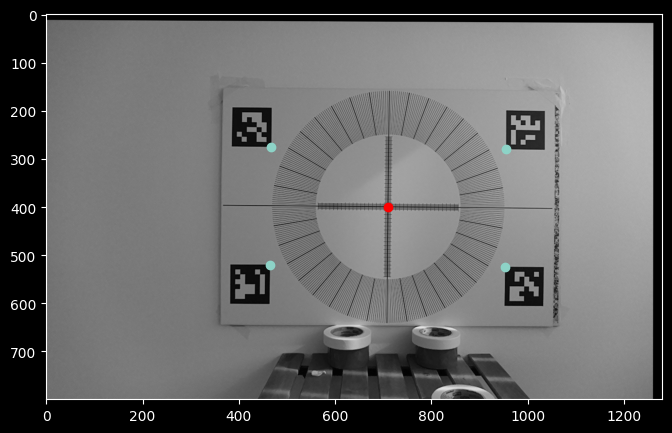

In [6]:
img = devices["194430103120731300"]["rectified_left"]

points = get_corners(img)

center = points.mean(axis=0).reshape((-1, 2))

plt.figure(figsize=(10,5))
plt.imshow(img)
plt.scatter(points[:, 0], points[:, 1])
k = 3
plt.scatter(center[:, 0], center[:, 1], c="r")

print(f"angle: {np.rad2deg(get_rotation(points))}")
print(f"center: {center}")

board_width = get_board_width(points)
print(f"width: {board_width} px; 1cm = {board_width/60}px")

In [31]:
results = []

offsets = { # compensation for different camera positions (in m)
    "right": -0.0375,
    "rectified_right": -0.0375,
    "color": 0,
    "left": 0.0375,
    "rectified_left": 0.0375,
}

for mxid, images in devices.items():
    result = {"mxid": mxid}

    for name, img in images.items():
        points = get_corners(img)
        center_x, center_y = get_center(points)
        angle = get_rotation(points)
        board_width = get_board_width(points)
        px2m = 0.6 / board_width

        offset = offsets[name]

        result[f"{name}_roll_angle"] = np.rad2deg(angle)
        result[f"{name}_yaw_angle"] = np.rad2deg(np.arctan2(offset + px2m * (img.shape[1]/2 - center_x), CAMERA_WALL_DISTANCE))
        result[f"{name}_pitch_angle"] = np.rad2deg(np.arctan2(px2m * (img.shape[0]/2 - center_y), CAMERA_WALL_DISTANCE))


    for cam_a, cam_b in combinations(["left", "right", "color"], 2):
        result[f"{cam_a}_{cam_b}_roll_diff"] = np.abs(result[f"{cam_a}_roll_angle"] - result[f"{cam_b}_roll_angle"])
        result[f"{cam_a}_{cam_b}_yaw_diff"] = np.abs(result[f"{cam_a}_yaw_angle"] - result[f"{cam_b}_yaw_angle"])
        result[f"{cam_a}_{cam_b}_pitch_diff"] = np.abs(result[f"{cam_a}_pitch_angle"] - result[f"{cam_b}_pitch_angle"])

    results.append(result)

results_df = pd.DataFrame(results)
results_df.transpose()

,0,1,2,3,4,5,6
mxid,194430103120731300,1944301041C7751300,1944301041D0731300,1944301041D7761300,19443010D1C47E1300,19443010E1E6731300,19443010F1A9761300
color_roll_angle,-0.489173,-0.946699,-0.734521,-0.702793,-0.763085,-0.547395,-0.489696
color_yaw_angle,-1.026046,-2.258286,-1.508612,-0.840923,-1.730153,-1.499795,-1.911104
color_pitch_angle,-0.595515,-0.073329,-0.598042,-0.537662,-0.206579,1.115815,-0.27574
left_roll_angle,-0.46771,-0.238731,-0.235784,-0.354402,-0.352947,-0.352947,-0.2353
left_yaw_angle,-3.856046,-1.38257,-1.140397,-1.925227,-1.200264,-2.385302,-2.860843
left_pitch_angle,1.124622,0.108105,-1.273006,0.693884,-1.080776,-0.088235,1.076355
rectified_left_roll_angle,-0.46771,0.0,0.705867,-0.2353,-0.235784,-0.350786,-0.47156
rectified_left_yaw_angle,-2.805259,0.777675,-1.281606,-2.386397,-1.437981,-2.340976,-1.64291
rectified_left_pitch_angle,-0.03515,0.246052,-0.51278,-0.301241,-1.029784,0.669197,-0.212632


In [29]:
results_df[["right_color_roll_diff", "right_color_yaw_diff", "right_color_pitch_diff"]].mean()

right_color_roll_diff     0.433080
right_color_yaw_diff      0.443151
right_color_pitch_diff    0.022166
dtype: float64

In [6]:
results_df.std(numeric_only=True)

color_center_x                 26.772522
color_center_y                 32.864849
color_roll_angle                0.168654
color_yaw_angle                 0.490793
color_pitch_angle               0.602023
left_center_x                  14.506362
left_center_y                  13.752922
left_roll_angle                 0.087601
left_yaw_angle                  0.997049
left_pitch_angle                0.971934
rectified_left_center_x        16.791527
rectified_left_center_y         7.678239
rectified_left_roll_angle       0.411156
rectified_left_yaw_angle        1.180213
rectified_left_pitch_angle      0.543335
rectified_right_center_x       16.482584
rectified_right_center_y        7.641327
rectified_right_roll_angle      0.432034
rectified_right_yaw_angle       1.156634
rectified_right_pitch_angle     0.539511
right_center_x                 15.096712
right_center_y                  7.557321
right_roll_angle                0.234696
right_yaw_angle                 1.063231
right_pitch_angl

In [30]:
results_df.transpose().to_excel("results.xlsx")

In [25]:
list(combinations([1,2,3], r=2))

[(1, 2), (1, 3), (2, 3)]